#🦕🦾 **Evaluating Grounding DINO 🦾🦕**

This notebook is used to evaluate the standard version of GroundingDINO and our finetuned version on the [Ot&Sien](https://data.4tu.nl/datasets/d1f3ca5c-f1e4-48f5-9a04-0564572d2b9c/1) dataset. The dataset should be in the following filestructure:
- Ot&Sien
    - train
        - images
        - labels
    - valid
        - images
        - labels
    - test
        - images
        - labels

The evaluation is done by looking at the mAP, the confusion matrix, the APs of frequent classes, detection accuracy and classification accuracy. At the end, you can also compare the two versions of the model on a single image and look at the model predictions of certain classes.

(Note: currently the groundingDINO model could not be improved by finetuning, so there are no finetuned parameter weights. You can use the base GroundingDINO model instead)

## Loading GroundingDINO and other modules

Load and install all modules necessary. This may take a while

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install supervision fastapi kaleido python-multipart uvicorn
!pip install -q roboflow dataclasses-json onemetric

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

import os, cv2, bisect
import supervision as sv
import torch
import torch.nn as nn

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HOME = os.getcwd()
print(HOME)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires ty

In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate, Model
from groundingdino.util.box_ops import box_iou, box_cxcywh_to_xyxy
from groundingdino.util.utils import get_phrases_from_posmap
# model = load_model(CONFIG_PATH, WEIGHTS_PATH)

from onemetric.cv.object_detection import MeanAveragePrecision,AveragePrecision,ConfusionMatrix

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 421 (delta 143), reused 127 (delta 127), pack-reused 233
Receiving objects: 100% (421/421), 12.85 MiB | 23.97 MiB/s, done.
Resolving deltas: 100% (215/215), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.9 MB/s eta 0:00:00
/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content
/content/weights
/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content/GroundingDINO


## Functions

Define functions, classes and variables that will be used. The functions and classes are as follows:
- load_data(DATA_DIRECTORY, dataset): A function that loads all images from a dataset and gives its image array, labels and bounding boxes.
- phrases2classes(phrases, classes): Converts the groundingDINO phrase output to one of the class labels
- get_batches(model,images,labels,bboxes,classes,prompt): run the model on the whole dataset and store the groundtruth and predictions in seperate lists
- class_detection_accuracy(GT_batch, DET_batch, class_ind, THRESHOLD = 0.5): calculate the amount of ground truth bounding boxes in a single image that are detected for a specified class
- class_classification_accuracy(GT_batch, DET_batch, class_ind, THRESHOLD = 0.5): calculate the amount of ground truth bounding boxes in a single image that are correctly classified for a specified class
- GroundingDINOV2(nn.Module): model class that uses GroundingDINO as a base
- compare_models(model1, model2, images, labels, bboxes, image_index, prompt, model_names=['model1','model2']): create 4 images in a 2x2 grid with the original image, the groundtruth annotations, the annotations from model1 and the annotations from model2


In [ ]:
# all classes present in Ot&Sien Dataset
classes = ['acorn', 'axe', 'backpack', 'badger', 'bag', 'barrel', 'basket', 'bear', 'bed', 'bee', 'bell', 'bench', 'bird', 'birdcage', 'boar', 'boat', 'book', 'bottle', 'bow', 'bowl', 'box', 'bridge', 'broom', 'brush', 'bucket', 'building', 'butterfly', 'camel', 'campfire', 'candle', 'cane', 'cannon', 'car', 'cat', 'cello', 'chair', 'clock', 'couch', 'cow', 'cradle', 'crown', 'cup', 'curtain', 'deer', 'diningTable', 'dog', 'doghouse', 'donkey', 'door', 'dragon', 'drum', 'egg', 'elephant', 'ermine', 'feather', 'female', 'fence', 'fireplace', 'fish', 'fishingRod', 'flag', 'flower', 'flute', 'fox', 'frog', 'glasses', 'globe', 'goat', 'gun', 'hammer', 'hat', 'hedgehog', 'helmet', 'horse', 'hotAirBalloon', 'inkpot', 'insect', 'jackal', 'jar', 'jug', 'kettle', 'kite', 'knife', 'ladder', 'lamp', 'lifebuoy', 'lion', 'lizard', 'lobster', 'male', 'map', 'marmot', 'melon', 'monkey', 'moon', 'musicSheet', 'nest', 'net', 'painting', 'paintingStand', 'pan', 'pear', 'pen', 'penguin', 'piano', 'pickaxe', 'pig', 'pineapple', 'pipe', 'plant', 'plate', 'pot', 'pottedPlant', 'rabbit', 'rake', 'rat', 'rhino', 'sausage', 'saw', 'scale', 'scissors', 'scorpion', 'seal', 'shark', 'sheep', 'shield', 'shovel', 'sieve', 'skate', 'snail', 'snake', 'spear', 'spoon', 'sportsBall', 'squirrel', 'star', 'stool', 'stroller', 'suitcase', 'sun', 'sunflower', 'sword', 'teachingBoard', 'teapot', 'tent', 'tie', 'tiger', 'train', 'tree', 'trumpet', 'tub', 'turtle', 'umbrella', 'vase', 'violin', 'wagon', 'walnut', 'weight', 'whip', 'windmill', 'window', 'wineGlass', 'wolf', 'zebra']

# lower all class names because GroundingDINO only outputs lowercased words
classes = [class_.lower() for class_ in classes]

# classes that occur most frequently (same as YOLO paper: https://repository.tudelft.nl/islandora/object/uuid%3A66dbab00-20fe-476a-9ce4-c5d31e1d196b)
frequent_classes = ['male','female','bird','hat','tree','dog','horse','chair','window','building','cat','basket','diningTable','flower','boat','book','curtain','cup']

# lower all class names because GroundingDINO only outputs lowercased words
frequent_classes = [class_.lower() for class_ in frequent_classes]


In [ ]:
def load_data(DATA_DIRECTORY, dataset):
    """
    Load a dataset into images, labels, bboxes

    Args:
        - DATA_DIRECTORY: the main data directory. The assumes the following file structure:
            --> DATA_DIRECTORY
                --> train
                    --> images
                    --> labels
                --> valid
                    --> images
                    --> labels
                --> test
                    --> images
                    --> labels
        - dataset: the specific dataset we want to load. Choice out of ['train', 'valid','test']

    Returns:
        - images: a list of tuples (image_source, image_transformed) of the original image as np.array and the image as tensor suitable as input for GroundingDINO.
        - labels: a list of class indices lists. Each element is a list with the classes that can be found in the corresponding image.
        - bboxes: a list of bounding boxes in xywh format. Each element is a list with the bounding boxes that can be found in the corresponding image.
    """
    # get directory paths
    IMAGE_DIRECTORY = os.fsdecode(DATA_DIRECTORY + '/' + dataset + '/images')
    BBOX_DIRECTORY = os.fsdecode(DATA_DIRECTORY + '/' + dataset + '/labels')
    image_files = os.listdir(IMAGE_DIRECTORY)

    images = []
    labels = []
    bboxes = []
    for filename in tqdm(image_files, desc = 'Loading Data'):
        # Load image
        IMAGE_PATH  = os.path.join(IMAGE_DIRECTORY, filename)
        image_source, image_transformed = load_image(IMAGE_PATH)
        images.append((image_source, image_transformed))

        # Load labels and bboxes
        BBOX_PATH = os.path.join(BBOX_DIRECTORY, filename[:-4] + '.txt')
        img_labels = []
        img_bboxes = []
        with open(BBOX_PATH) as f:
            split1 = f.read().split('\n')
            for s in split1:
                split2 = s.split()
                img_labels.append(int(split2[0]))
                bbox = [float(split2[1]),float(split2[2]),float(split2[3]),float(split2[4])]
                img_bboxes.append(bbox)
        labels.append(img_labels)
        bboxes.append(img_bboxes)
    print(f"Succesfully loaded {len(images)} images")
    return images, labels, bboxes

In [ ]:
def phrases2classes(phrases, classes):
    """
    Changes the returned phrases from GroundingDINO to a class_id. It gives the class of the first word from the phrase if possible and otherwise the first class from classes that is in the phrase.
    If there is no class, it returns None.
    Slightly altered from the groundingDINO function since it gave unwanted results for substrings(ex. 'dog' and 'doghouse') and phrases with multiple words.

    Args:
        - phrases: a list of phrases, one for each bounding box prediction
        - classes: the list with all different classes(in string format)

    Returns:
        - a numpy array with the class ids for each bounding box.

    Example:
        >> phrases = ['cat', 'doghouse', 'cat doghouse', 'horse doghouse']
        >> classes = ['cat','dog','doghouse']
        >> phrases2classes(phrases,classes)
        ... [0,2,0,1]
    """
    class_ids = []
    for phrase in phrases:
        first_word = phrase.split()[0]
        for class_ in classes:
            # check if first word of phrase is a class
            if class_ == first_word:
                class_ids.append(classes.index(class_))
                break
        else:
            for class_ in classes:
                # check if the phrase contains a class
                if class_ in phrase:
                    class_ids.append(classes.index(class_))
                    break
            else:
                class_ids.append(None)


    return np.array(class_ids)

In [ ]:
def get_batches(model,images,labels,bboxes,classes,prompt):
    """
    run the model on the whole dataset and store the groundtruth and predictions in seperate lists.

    Args:
        - model: the model of GroundingDINOV2 type
        - images: a list of tuples (image_source, image_transformed) of the original image as np.array and the image as tensor suitable as input for GroundingDINO.
        - labels: a list of class indices lists. Each element is a list with the classes that can be found in the corresponding image.
        - bboxes: a list of bounding boxes in xywh format with values in [0,1]. Each element is a list with the bounding boxes that can be found in the corresponding image.
        - classes: a list of all classes as strings
        - prompt: the prompt used for GroundingDINO

    Returns:
        - GT_batches: a list of np.arrays of shape (N,5). Each element contains the groundtruth bounding box information for that image in the dataset.
                      Each row of the np.array is in (x_min,y_min,x_max,y_max,class) format. The bounding box coordinates have values between 0 and 1.
        - DET_batches: a list of np.arrays of shape (M,6). Each element contains the predicted bounding box information for that image in the dataset.
                       Each row of the np.array is in (x_min,y_min,x_max,y_max,class,conf) format. The bounding box coordinates have values between 0 and 1.
    """

    model.eval()
    with torch.no_grad():
        GT_batches, DET_batches = [], []

        # loop over all images in dataset
        for k in tqdm(range(len(images)), desc = 'Running model'):
            # get image and groundtruth information
            image_source, image_transformed = images[k]
            h,w,rgb = image_source.shape
            img_labels = labels[k]
            xywh_bboxes = bboxes[k]

            # bboxes from are in xywh format, but onemetric needs xyxy format in numpy array
            xyxy_GT_bboxes = box_cxcywh_to_xyxy(torch.tensor(xywh_bboxes)).numpy()

            # turn img_labels into np.array and make it shape (N,1)
            labels_np = np.array(img_labels)
            labels_np = np.reshape(labels_np,(len(labels_np),1))

            # add bbox info and labels together and append to GT_batches
            ground_truth = np.hstack((xyxy_GT_bboxes,labels_np))
            GT_batches.append(ground_truth)

            # create detections batches
            boxes, logits, phrases, _ = model(image_transformed.to(device),prompt)
            boxes, logits = boxes.cpu(), logits.cpu()
            xyxy_DET_bboxes = box_cxcywh_to_xyxy(torch.tensor(boxes)).numpy()

            # convert the phrase string to a class index
            class_ids = phrases2classes(phrases=phrases, classes=classes).reshape(-1, 1)
            logits_np = logits.numpy().reshape(-1, 1)
            detections = np.hstack((xyxy_DET_bboxes,class_ids,logits_np))

            # Remove detections if the phrase is not a class
            detections_to_keep = []
            for i in range(len(detections)):
                x0,y0,x1,y1,class_,conf = detections[i]
                if class_ is not None:
                    detections_to_keep.append(i)
            detections = detections[detections_to_keep]

            # Append data to DET_batches
            DET_batches.append(detections)

    return GT_batches, DET_batches


In [ ]:
def class_detection_accuracy(GT_batch, DET_batch, class_ind, THRESHOLD = 0.5):
    """
    Calculates the amount of detected vs not-detected instances of a certain class in a single image.
    An object is detected if the highest IoU between the GT bounding box and the detected bounding boxes is at least THRESHOLD.
    The predicted label does not have to match the GT label.
    The amount of rows between GT_batch and DET_batch can be different.

    Args:
        - GT_batch: The ground truth bounding box info for a single image. Should be a numpy array of shape (N,5), where M is the amount of ground truth bounding boxes.
                    Each row is expected to be in the format (x_min,y_min,x_max,y_max,class) with values in [0,1]
        - DET_batch: The predicted bounding box info for a single image. Should be a numpy array of shape (M,5), where M is the amount of detected bounding boxes.
                    Each row is expected to be in the format (x_min,y_min,x_max,y_max,class) with values in [0,1]
        - class_ind: The index of the class we want the detection accuracy for.
        - THRESHOLD: The value determining when a bounding box is detected. The IoU should be at least this value.

    Returns:
        - tuple[detected,non_detected]: A tuple containing the amount of objects that were detected by the model and the amount of objects that were not detected of a certain class.
    """

    detected, not_detected = 0, 0

    # split GT_batch and DET_batch into bbox info and labels
    GT_boxes = torch.tensor(GT_batch[:,:4],dtype=float)
    GT_labels = GT_batch[:,4]
    DET_boxes = torch.tensor(DET_batch[:,:4],dtype=float)
    DET_labels = DET_batch[:,4]

    # if GroundingDINO returned no predictions, all class occurances are not detected
    if DET_boxes.shape[0] == 0:
        return 0, sum([x == c for x in GT_labels])

    # Calculate pairwise IoU for each pair
    iou = box_iou(GT_boxes, DET_boxes)[0]

    # Find maximum IoU for each groundtruth box
    max_iou, max_indices = torch.max(iou,dim=1)

    # Check if the class is detected or not
    max_iou = max_iou.numpy()
    for k in range(len(max_iou)):
        if GT_labels[k] == class_ind:

            # only detected if the iou >= THRESHOLD
            if max_iou[k] >= THRESHOLD:
                detected += 1
            else:
                not_detected += 1
    return detected, not_detected

In [ ]:
def class_classification_accuracy(GT_batch, DET_batch, class_ind, THRESHOLD = 0.5):
    """
    Calculates the amount of detected vs not-detected instances of a certain class in a single image.
    An object is detected if the highest IoU between the GT bounding box and the detected bounding boxes is at least THRESHOLD.
    The predicted label has to match the GT label.
    The amount of rows between GT_batch and DET_batch can be different.

    Args:
        - GT_batch: The ground truth bounding box info. Should be a numpy array of shape (N,5), where M is the amount of ground truth bounding boxes.
                    Each row is expected to be in the format (x_min,y_min,x_max,y_max,class) with values in [0,1]
        - DET_batch: The predicted bounding box info. Should be a numpy array of shape (M,5), where M is the amount of detected bounding boxes.
                    Each row is expected to be in the format (x_min,y_min,x_max,y_max,class) with values in [0,1]
        - class_ind: The index of the class we want the classification accuracy for.
        - THRESHOLD: The value determining when a bounding box is detected. The IoU should be at least this value.

    Returns:
        - tuple[detected,non_detected]: A tuple containing the amount of objects that were detected and correctly classified by the model and the amount of objects that were not detected or not correctly classified of a certain class.
    """
    detected, not_detected = 0, 0

    # split GT_batch and DET_batch into bbox info and labels
    GT_boxes = torch.tensor(GT_batch[:,:4],dtype=float)
    GT_labels = GT_batch[:,4]
    DET_boxes = torch.tensor(DET_batch[:,:4],dtype=float)
    DET_labels = DET_batch[:,4]

    # if GroundingDINO returned no predictions, all class occurances are not detected
    if DET_boxes.shape[0] == 0:
        return 0, sum([x == c for x in GT_labels])

    # Calculate pairwise IoU for each pair
    iou = box_iou(GT_boxes, DET_boxes)[0]

    # Find maximum IoU for each groundtruth box
    max_iou, max_indices = torch.max(iou,dim=1)

    # check if the class is detected or not
    max_iou = max_iou.numpy()
    for k in range(len(max_iou)):
        if GT_labels[k] == class_ind:

            # only detected if the iou >= THRESHOLD and the label matches
            if max_iou[k] >= THRESHOLD and DET_labels[max_indices[k]] == class_ind:
                detected += 1
            else:
                not_detected += 1
    return detected, not_detected

In [ ]:
def preprocess_caption(caption: str) -> str:
    """
    Function from groundingDINO that preprocesses the input prompt. It does so by stripping the prompt and adding a "." if necessary.

    Args:
        - caption: the input prompt to groundingDINO

    Returns:
        - preprocessed prompt
    """
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

In [ ]:
class GroundingDINOV2(nn.Module):
    def __init__(self, box_threshold=0.35, text_threshold=0.25, WEIGHTS_PATH=WEIGHTS_PATH):
        super(GroundingDINOV2, self).__init__()

        self.box_threshold = box_threshold
        self.text_threshold = text_threshold

        self.basemodel = load_model(CONFIG_PATH, WEIGHTS_PATH)

    def basemodel_forward(self, image, caption, remove_combined=False):
        """
        This function is mainly from the GD Github and slightly modified to also output
        the prediction_logits without the mask .max(dim=1)[0] being applied.
        """
        caption = preprocess_caption(caption)
        outputs = self.basemodel(image[None], captions=[caption])

        prediction_logits = outputs["pred_logits"].sigmoid()[0]  # prediction_logits.shape = (nq, 256)
        prediction_logits_no_sigmoid = outputs["pred_logits"][0]  # prediction_logits.shape = (nq, 256)
        prediction_boxes = outputs["pred_boxes"][0]  # prediction_boxes.shape = (nq, 4)

        mask = prediction_logits.max(dim=1)[0] > self.box_threshold
        logits = prediction_logits[mask]  # logits.shape = (n, 256)
        boxes = prediction_boxes[mask]  # boxes.shape = (n, 4)

        logits_raw = prediction_logits[mask]

        tokenizer = self.basemodel.tokenizer
        tokenized = tokenizer(caption)

        if remove_combined:
            sep_idx = [i for i in range(len(tokenized['input_ids'])) if tokenized['input_ids'][i] in [101, 102, 1012]]

            phrases = []
            for logit in logits:
                max_idx = logit.argmax()
                insert_idx = bisect.bisect_left(sep_idx, max_idx)
                right_idx = sep_idx[insert_idx]
                left_idx = sep_idx[insert_idx - 1]
                phrases.append(get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer, left_idx, right_idx).replace('.', ''))
        else:
            phrases = [
                get_phrases_from_posmap(logit > self.text_threshold, tokenized, tokenizer).replace('.', '')
                for logit
                in logits
            ]

        return boxes, logits.max(dim=1)[0], phrases, logits_raw

    def forward(self, image, caption):
        """
        The forward function of the module. Also used met model(image, caption) is called.
        The forward functoin sends the inputs to self.basemodel_forward and returns self.basemodel_forward's outpus

        Args:
            - image: image in torch.tensor format
            - caption: string in format 'cls. cls2. cls3.'

        Returns:
            - boxes: found bounding boxes in cxcywh format
            - logits: probability of each final prediction
            - phrases: the found classes
            - logits_raw: the entire logits torch.tensor for each prediction
        """
        return self.basemodel_forward(image, caption)

In [ ]:
def compare_models(model1, model2, images, labels, bboxes, image_index, prompt, model_names=['model1','model2']):
    """
    Plot 4 images in a 2x2 grid with the original image, the groundtruth annotations, the annotations from model1 and the annotations from model2.

    Args:
        - model1: a model of GroundingDINOV2 type
        - model2: a model of GroundingDINOV2 type
        - images: a list of tuples (image_source, image_transformed) of the original image as np.array and the image as tensor suitable as input for GroundingDINO.
        - labels: a list of class indices lists. Each element is a list with the classes that can be found in the corresponding image.
        - bboxes: a list of bounding boxes in xywh format with values in [0,1]. Each element is a list with the bounding boxes that can be found in the corresponding image.
        - image_index: the index of the image on which we want to compare the 2 models
        - prompt: the prompt used for groundingDINO
        - model_names: a list of the names of the two models we want to compare


    """
    # Get image and bbox information
    image_source, image_transformed = images[image_index]
    img_labels = labels[image_index]
    img_bboxes = bboxes[image_index]

    # set image to RGB
    image_rgb = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)

    # Get ground truth annotations
    ground_truth_image = annotate(image_source=image_source, boxes=torch.tensor(img_bboxes), logits = torch.tensor([1 for box in img_bboxes]),phrases=[classes[k] for k in img_labels])

    model1.eval()
    model2.eval()

    with torch.no_grad():
        # Apply model1
        boxes, logits, phrases, _ = model1(image_transformed.to(device), prompt)
        boxes, logits = boxes.cpu(), logits.cpu()
        predicted_image1 = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

        # Apply model2
        boxes, logits, phrases, _ = model2(image_transformed.to(device), prompt)
        boxes, logits = boxes.cpu(), logits.cpu()
        predicted_image2 = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

    # set names for model in plot
    model1_name, model2_name = model_names

    # Plot images in a (2,2) grid
    img_list = [image_rgb,ground_truth_image,predicted_image1,predicted_image2]
    sv.plot_images_grid(images=img_list,grid_size=(2,2),titles=['Original image','Groundtruth bounding boxes',f'{model1_name} predictions', f'{model2_name} predictions'],size=(8,8))

## Import Data

Import the images, labels and bounding box info, initialize the model and run it on all images

In [ ]:
# Set the directory of the Ot&Sien Dataset

DATA_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/Capstone/1.0_Children_Books'
dataset = 'valid' # choice of: 'train', 'valid' and 'test'
images, labels, bboxes = load_data(DATA_DIRECTORY, dataset)

Loading Data:   0%|          | 0/259 [00:00<?, ?it/s]

Succesfully loaded 259 images


In [ ]:
## Import unfinetuned model
unfinetuned_model = GroundingDINOV2()
unfinetuned_model = unfinetuned_model.to(device)


## Import finetuned model
finetuned_weights_path = None # set path to a finetuned model weights

# if no path given, use basemodel
if finetuned_weights_path is None:
    finetuned_weights_path = WEIGHTS_PATH

finetuned_model = GroundingDINOV2(WEIGHTS_PATH = finetuned_weights_path)
finetuned_model = finetuned_model.to(device)

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

final text_encoder_type: bert-base-uncased


In [ ]:
# Select which model to use for evaluation. True if you want to use the finetuned model, False if you want to use the unfinetuned model.
use_finetuned_model = False

if use_finetuned_model:
    model = finetuned_model
    model_name = 'finetuned'
else:
    model = unfinetuned_model
    model_name = 'unfinetuned'
print(f"Current model: {model_name} GroundingDINO")

Current model: unfinetuned GroundingDINO


In [ ]:
# run the model on dataset with the frequent classes as prompt
freq_classes_prompt = '. '.join(frequent_classes)
GT_batches, DET_batches = get_batches(model, images, labels, bboxes, classes, freq_classes_prompt)

Running model:   0%|          | 0/259 [00:00<?, ?it/s]

## mAP and Confusion matrix

Calculate the mean average precision on all classes and plot a confusion matrix

In [ ]:
iou_threshold = 0.5
mean_average_precision = MeanAveragePrecision.from_detections(
    true_batches = GT_batches,
    detection_batches = DET_batches,
    num_classes = len(classes),
    iou_threshold = iou_threshold
)

print(f"mAP_{iou_threshold} =", mean_average_precision.value)

mAP_0.5 = 0.027850782109256032


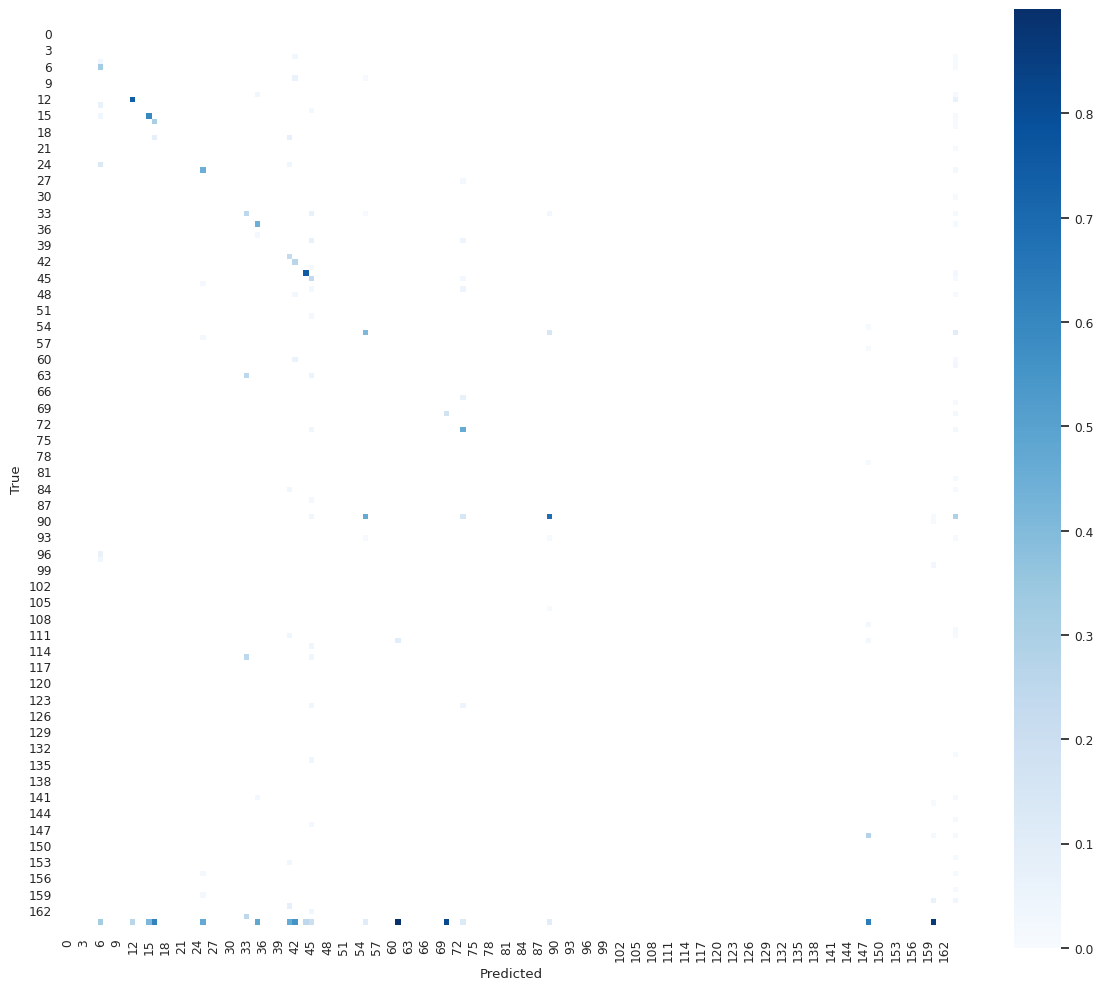

In [ ]:
confusion_matrix = ConfusionMatrix.from_detections(
    true_batches = GT_batches,
    detection_batches = DET_batches,
    num_classes = len(classes),
    conf_threshold = 0.3,
    iou_threshold = 0.5
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=classes)

## Frequent class APs

For the most frequent classes(from YOLO paper), compute the average precision and plot a bar chart

In [ ]:
# Create a list with the class APs for the frequent classes
frequent_APs = []
iou_threshold = 0.5
for class_ in frequent_classes:
    class_idx = classes.index(class_)
    average_precision = AveragePrecision.from_detections(
        true_batches = GT_batches,
        detection_batches = DET_batches,
        class_idx = class_idx,
        iou_threshold = iou_threshold
    )
    frequent_APs.append(average_precision.value)
print(f"The mAP over the frequent classes is: mAP = {np.mean(frequent_APs)}")

The mAP over the frequent classes is: mAP = 0.25375157032877715


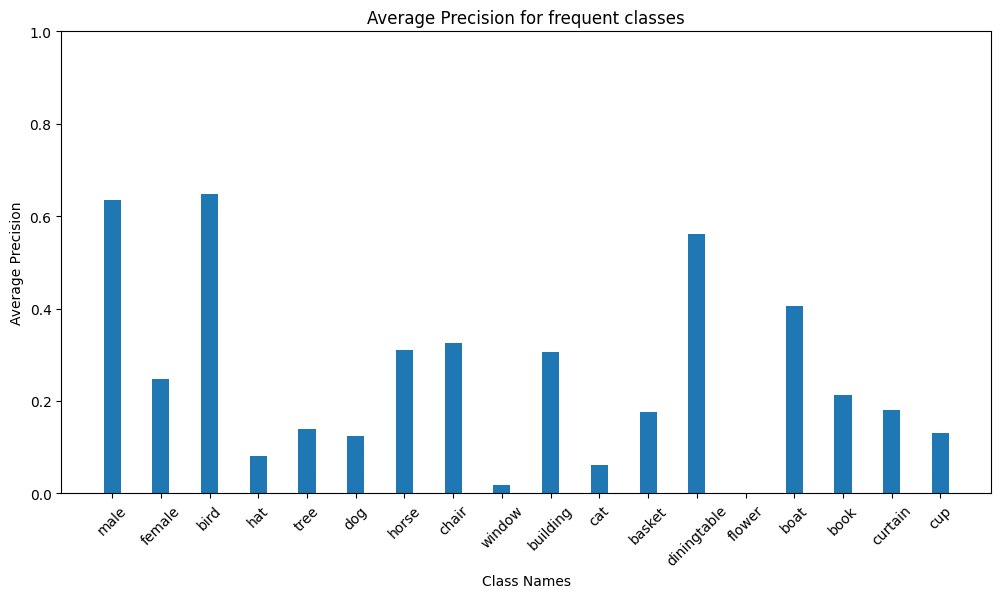

In [ ]:
# Create a barplot with the class APs for the frequent classes
bar_width = 0.35
plt.figure(figsize=(12, 6))
x = np.arange(len(frequent_classes))
plt.bar(x, frequent_APs, bar_width)

plt.title("Average Precision for frequent classes")
plt.xlabel('Class Names')
plt.ylabel('Average Precision')
plt.xticks(x, frequent_classes, rotation=45)
plt.ylim([0,1])
plt.show()

## Class accuracies

For the most frequent classes(from YOLO paper), compute the detection and classification accuracies. Make bar charts to compare them to the values from the YOLO paper.

In [ ]:
# Create a dictionary detection_rates with as keys the class name and as values a tuple (total_detected,total_not_detected).
# This tuple gives the total amount of times the class is detected and not detected across all images in the dataset

detection_accuracy = dict()
for c in range(len(classes)):
    total_detected, total_not_detected = 0,0
    for k in range(len(GT_batches)):
        GT_batch = np.array(GT_batches[k],dtype=float)
        DET_batch = np.array(DET_batches[k][:,:5],dtype=float)
        detected, not_detected = class_detection_accuracy(GT_batch, DET_batch, c)
        total_detected, total_not_detected = total_detected + detected, total_not_detected + not_detected
    detection_accuracy[classes[c]] = (total_detected, total_not_detected)
print(detection_accuracy)

{'acorn': (0, 0), 'axe': (0, 2), 'backpack': (0, 2), 'badger': (0, 0), 'bag': (1, 6), 'barrel': (1, 6), 'basket': (10, 8), 'bear': (1, 2), 'bed': (3, 2), 'bee': (0, 0), 'bell': (0, 1), 'bench': (2, 4), 'bird': (45, 51), 'birdcage': (2, 0), 'boar': (1, 0), 'boat': (14, 7), 'book': (4, 5), 'bottle': (0, 6), 'bow': (0, 3), 'bowl': (3, 2), 'box': (0, 3), 'bridge': (0, 4), 'broom': (0, 1), 'brush': (0, 0), 'bucket': (5, 2), 'building': (23, 16), 'butterfly': (0, 0), 'camel': (1, 0), 'campfire': (0, 0), 'candle': (0, 1), 'cane': (0, 5), 'cannon': (0, 2), 'car': (0, 0), 'cat': (12, 12), 'cello': (0, 0), 'chair': (24, 11), 'clock': (0, 3), 'couch': (1, 0), 'cow': (6, 1), 'cradle': (0, 0), 'crown': (1, 0), 'cup': (6, 3), 'curtain': (9, 1), 'deer': (1, 0), 'diningtable': (3, 16), 'dog': (15, 8), 'doghouse': (1, 0), 'donkey': (3, 0), 'door': (1, 5), 'dragon': (0, 0), 'drum': (0, 1), 'egg': (0, 0), 'elephant': (1, 0), 'ermine': (0, 0), 'feather': (1, 1), 'female': (100, 79), 'fence': (1, 3), 'fire

In [ ]:
# Create a dictionary classification_accuracy with as keys the class name and as values a tuple (total_detected,total_not_detected).
# This tuple gives the total amount of times the class is correctly and incorrectly classified across all images in the dataset

classification_accuracy = dict()
for c in range(len(classes)):
    total_detected, total_not_detected = 0,0
    for k in range(len(GT_batches)):
        GT_batch = np.array(GT_batches[k],dtype=float)
        DET_batch = np.array(DET_batches[k][:,:5],dtype=float)
        detected, not_detected = class_classification_accuracy(GT_batch, DET_batch, c)
        total_detected, total_not_detected = total_detected + detected, total_not_detected + not_detected
    classification_accuracy[classes[c]] = (total_detected, total_not_detected)
print(classification_accuracy)

{'acorn': (0, 0), 'axe': (0, 2), 'backpack': (0, 2), 'badger': (0, 0), 'bag': (0, 7), 'barrel': (0, 7), 'basket': (10, 8), 'bear': (0, 3), 'bed': (0, 5), 'bee': (0, 0), 'bell': (0, 1), 'bench': (0, 6), 'bird': (45, 51), 'birdcage': (0, 2), 'boar': (0, 1), 'boat': (13, 8), 'book': (4, 5), 'bottle': (0, 6), 'bow': (0, 3), 'bowl': (0, 5), 'box': (0, 3), 'bridge': (0, 4), 'broom': (0, 1), 'brush': (0, 0), 'bucket': (0, 7), 'building': (22, 17), 'butterfly': (0, 0), 'camel': (0, 1), 'campfire': (0, 0), 'candle': (0, 1), 'cane': (0, 5), 'cannon': (0, 2), 'car': (0, 0), 'cat': (1, 23), 'cello': (0, 0), 'chair': (24, 11), 'clock': (0, 3), 'couch': (0, 1), 'cow': (0, 7), 'cradle': (0, 0), 'crown': (0, 1), 'cup': (6, 3), 'curtain': (9, 1), 'deer': (0, 1), 'diningtable': (3, 16), 'dog': (13, 10), 'doghouse': (0, 1), 'donkey': (0, 3), 'door': (0, 6), 'dragon': (0, 0), 'drum': (0, 1), 'egg': (0, 0), 'elephant': (0, 1), 'ermine': (0, 0), 'feather': (0, 2), 'female': (67, 112), 'fence': (0, 4), 'fire

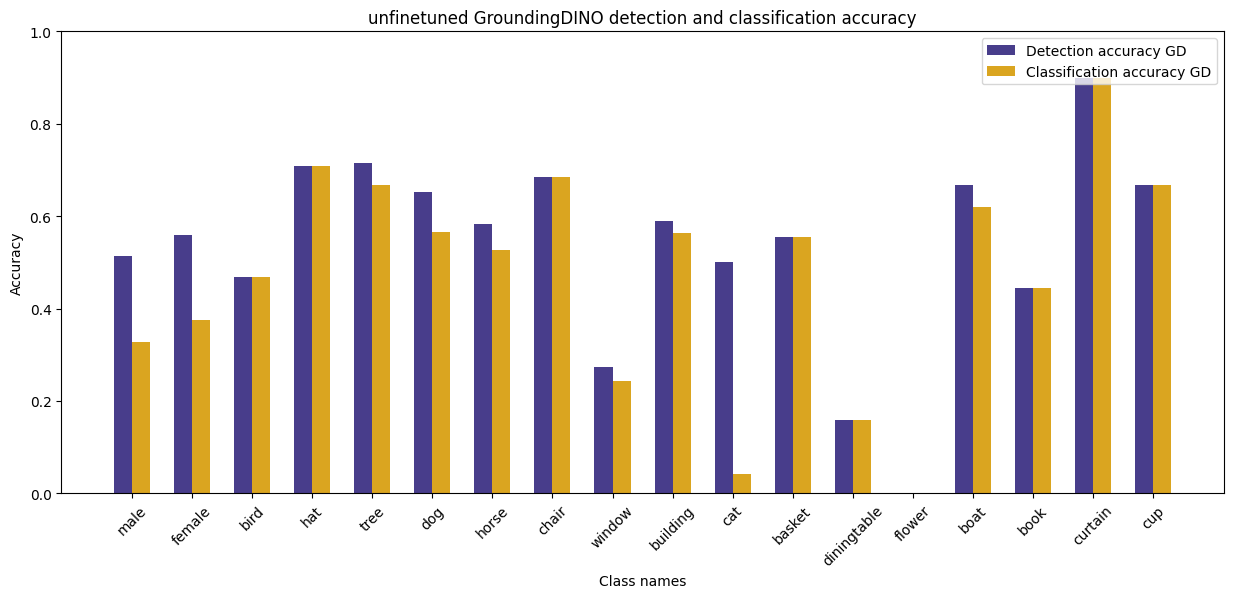

In [ ]:
# Create a barplot with the detection and classification accuracy of the model
det_acc_GD = [detection_accuracy[c][0]/(detection_accuracy[c][0]+detection_accuracy[c][1]) for c in frequent_classes]
class_acc_GD = [classification_accuracy[c][0]/(classification_accuracy[c][0]+classification_accuracy[c][1]) for c in frequent_classes]

bar_width = 0.3
plt.figure(figsize=(15, 6))
x = np.arange(len(frequent_classes))
plt.bar(x - bar_width/2, det_acc_GD, bar_width, label='Detection accuracy GD', color='darkslateblue')
plt.bar(x + bar_width/2, class_acc_GD, bar_width, label='Classification accuracy GD', color='goldenrod')

plt.title(f"{model_name} GroundingDINO detection and classification accuracy")
plt.xlabel('Class names')
plt.ylabel('Accuracy')
plt.xticks(x, frequent_classes, rotation=45)
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

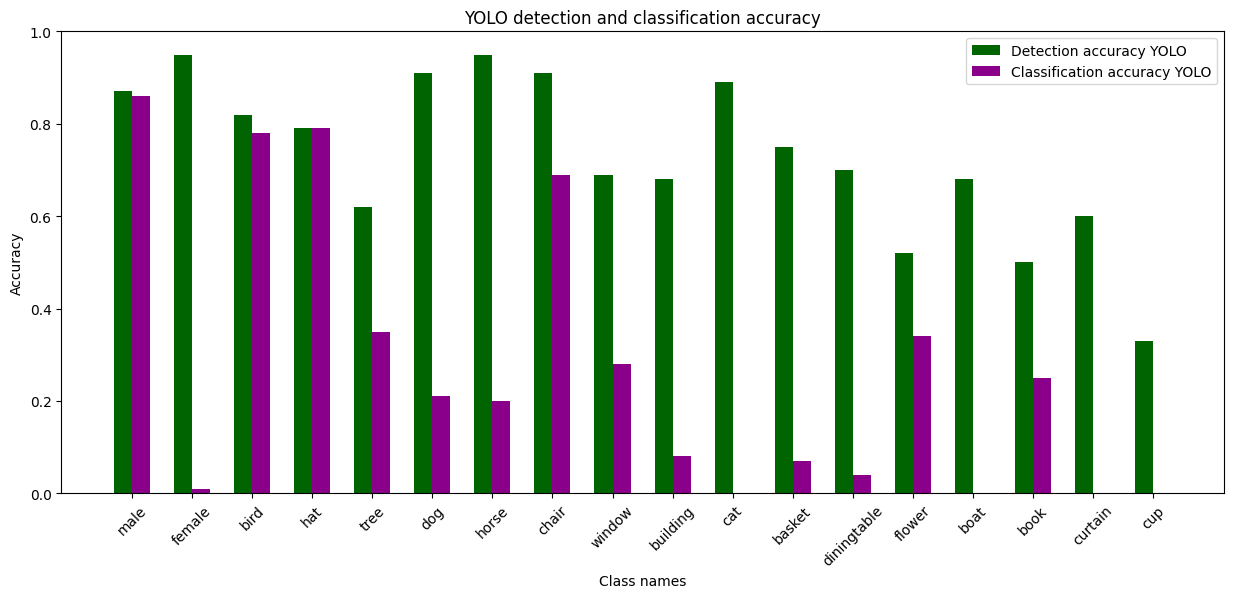

In [ ]:
# Approximate value of detection and classification accuracy from the YOLO paper: https://repository.tudelft.nl/islandora/object/uuid%3A66dbab00-20fe-476a-9ce4-c5d31e1d196b
det_acc_YOLO = [0.87,0.95,0.82,0.79,0.62,0.91,0.95,0.91,0.69,0.68,0.89,0.75,0.7,0.52,0.68,0.5,0.6,0.33]
class_acc_YOLO = [0.86,0.01,0.78,0.79,0.35,0.21,0.2,0.69,0.28,0.08,0,0.07,0.04,0.34,0,0.25,0,0]

bar_width = 0.3
plt.figure(figsize=(15, 6))
x = np.arange(len(frequent_classes))
plt.bar(x - bar_width/2, det_acc_YOLO, bar_width, label='Detection accuracy YOLO',color = 'darkgreen')
plt.bar(x + bar_width/2, class_acc_YOLO, bar_width, label='Classification accuracy YOLO', color = 'darkmagenta')

plt.title("YOLO detection and classification accuracy")
plt.xlabel('Class names')
plt.ylabel('Accuracy')
plt.xticks(x, frequent_classes, rotation=45)
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

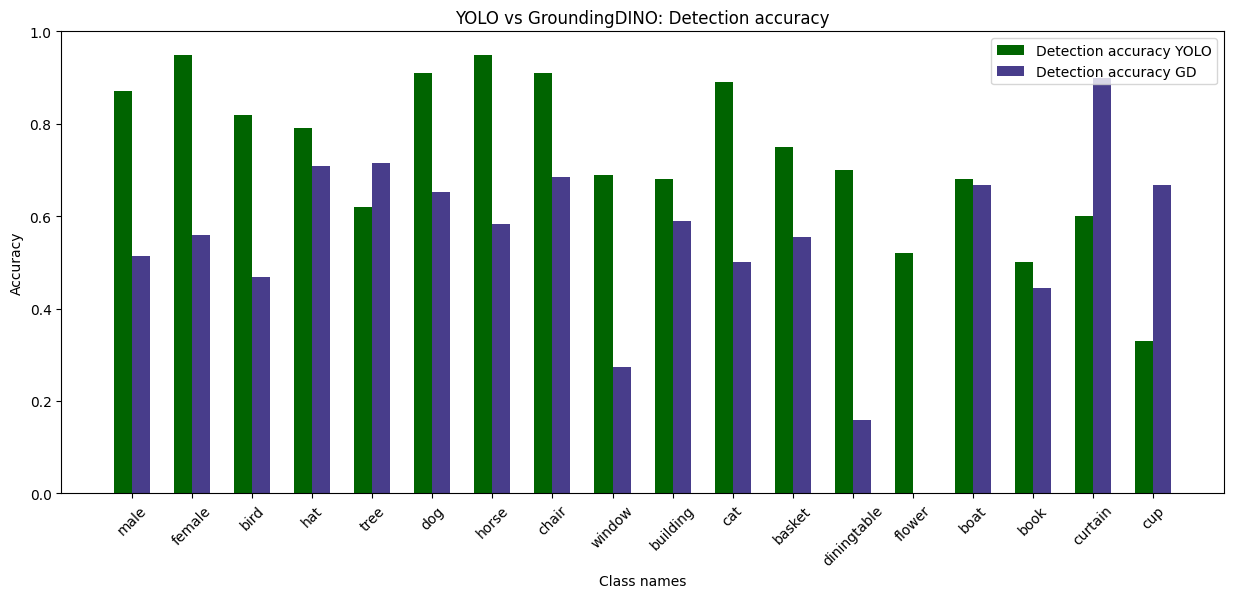

In [ ]:
# Create a barplot with the detection accuracy of the model and of YOLO
bar_width = 0.3
plt.figure(figsize=(15, 6))
x = np.arange(len(frequent_classes))
plt.bar(x - bar_width/2, det_acc_YOLO, bar_width, label='Detection accuracy YOLO',color = 'darkgreen')
plt.bar(x + bar_width/2, det_acc_GD, bar_width, label='Detection accuracy GD', color='darkslateblue')

plt.title("YOLO vs GroundingDINO: Detection accuracy")
plt.xlabel('Class names')
plt.ylabel('Accuracy')
plt.xticks(x, frequent_classes, rotation=45)
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

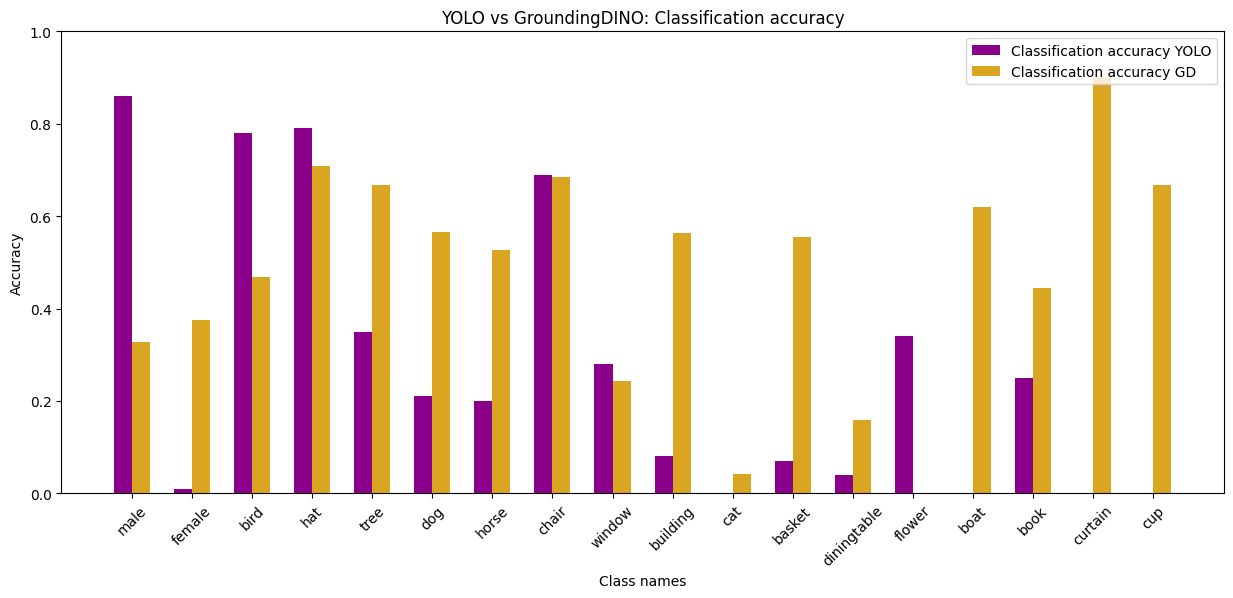

In [ ]:
# Create a barplot with the classification accuracy of the model and of YOLO
bar_width = 0.3
plt.figure(figsize=(15, 6))
x = np.arange(len(frequent_classes))
plt.bar(x - bar_width/2, class_acc_YOLO, bar_width, label='Classification accuracy YOLO', color = 'darkmagenta')
plt.bar(x + bar_width/2, class_acc_GD, bar_width, label='Classification accuracy GD', color='goldenrod')

plt.title("YOLO vs GroundingDINO: Classification accuracy")
plt.xlabel('Class names')
plt.ylabel('Accuracy')
plt.xticks(x, frequent_classes, rotation=45)
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

## Comparing models

Compare the finetuned and unfinetuned models on a single image with a specified prompt

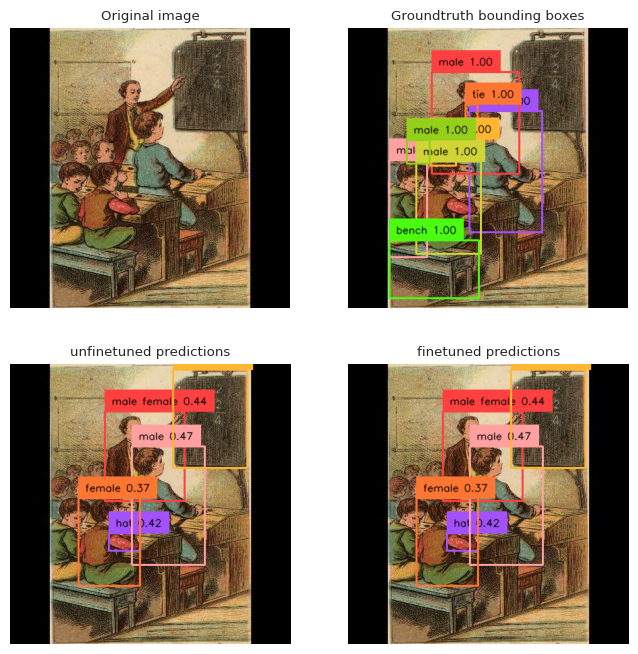

In [ ]:
compare_models(unfinetuned_model, finetuned_model, images, labels, bboxes, 5, freq_classes_prompt, model_names = ['unfinetuned','finetuned'])

## Plotting images containing a specific class

Plot images that contain a specific class to get a better understanding why it is/isn't detecting some classes

In [ ]:
# find all image indices of the class we want to analyse
class_ = 'cat'
class_index = classes.index(class_)
images_containing_class = []
for k in range(len(images)):
    if class_index in labels[k]:
        images_containing_class.append(k)

# plot at most 25 images
if len(images_containing_class) > 25:
    images_containing_class = images_containing_class[:50]

['book', 'female', 'male female', 'dog horse cat', 'curtain']


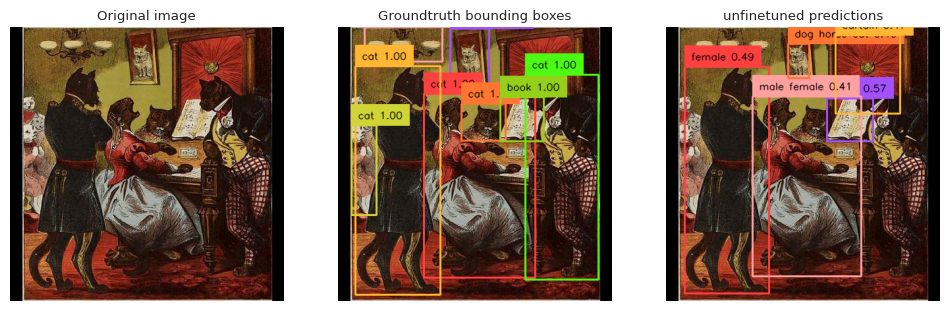

['female', 'male', 'window', 'building', 'tree']


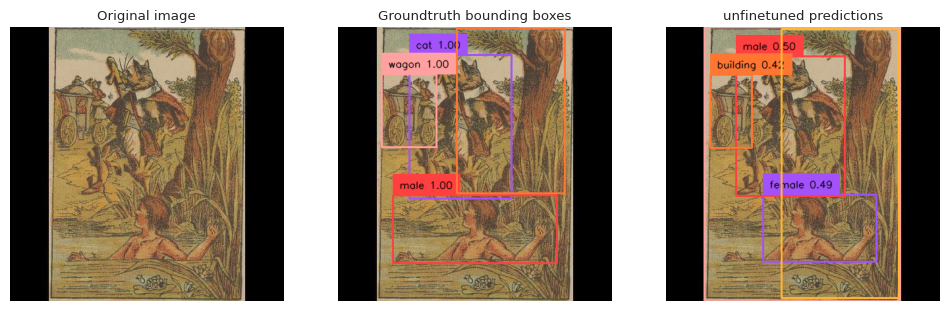

['male', 'hat', 'male female']


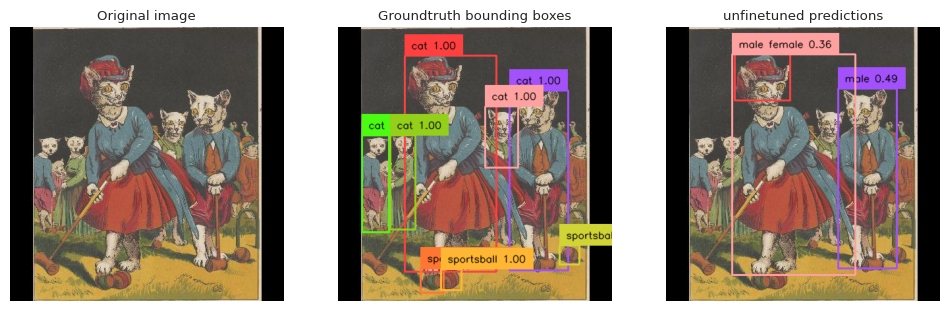

['window', 'female', 'hat', 'hat', 'hat', 'male']


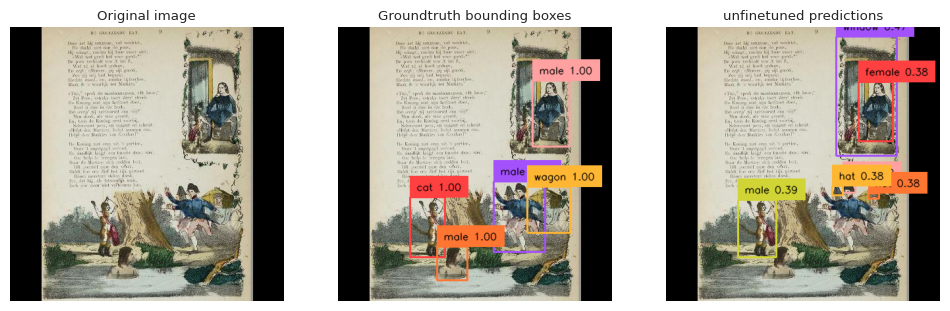

['dog horse', 'tree', 'male female', 'basket', 'female', 'male', 'dog', 'cup']


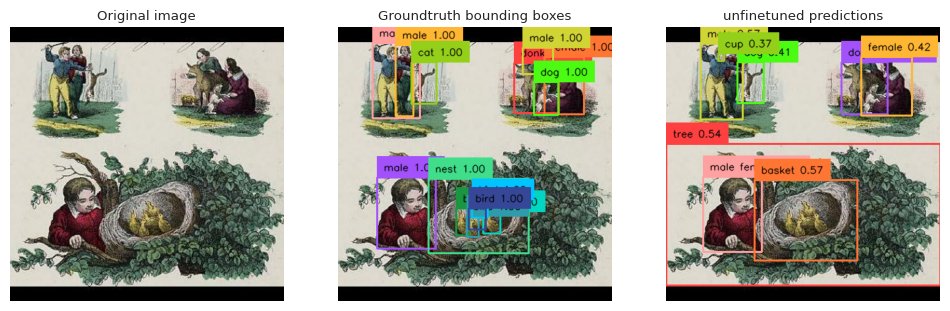

['window', 'bird', 'curtain', 'hat', 'cup', 'male']


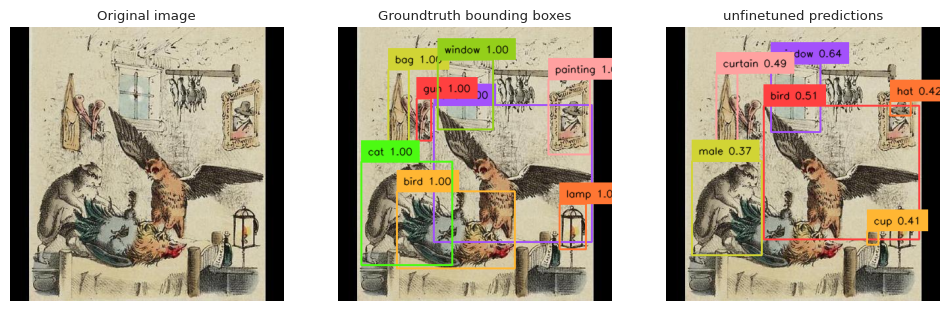

['chair', 'dog', 'book', 'male female']


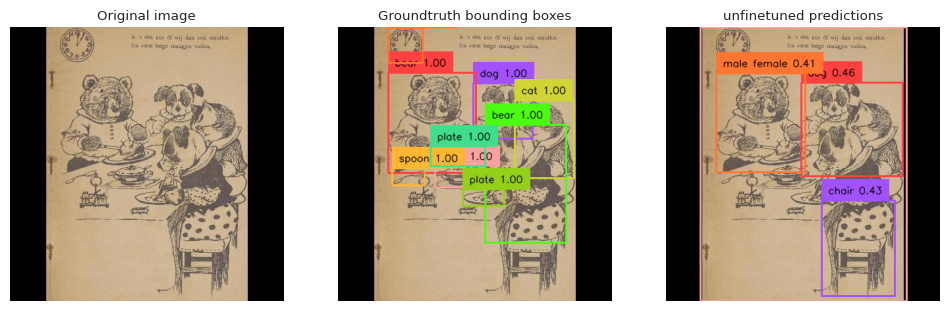

['chair', 'cup']


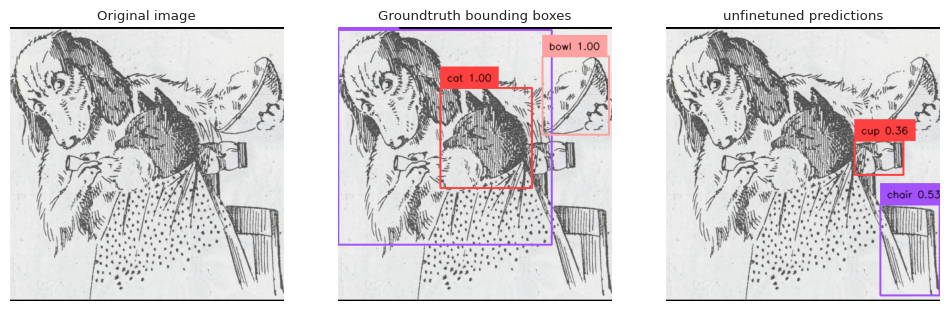

['window', 'curtain', 'female', 'male female', 'male', 'dog']


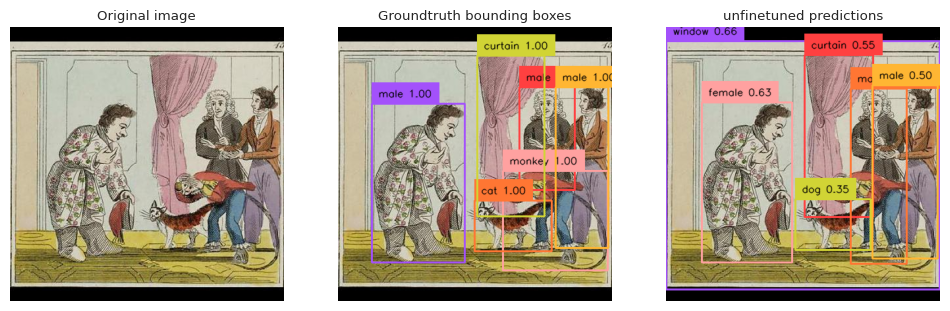

['tree', 'male female', 'window']


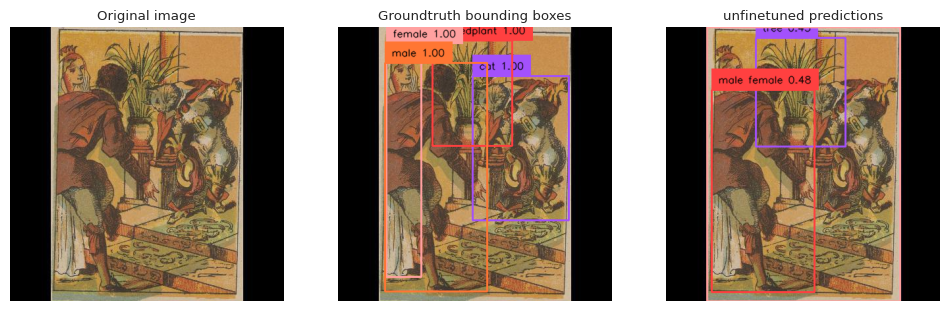

['female', 'hat', 'bird', 'dog', 'bird', 'bird', 'chair', 'dog', 'boat', 'bird', 'flower', 'basket', 'tree', 'male', 'bird', 'building', 'boat', 'curtain', 'boat']


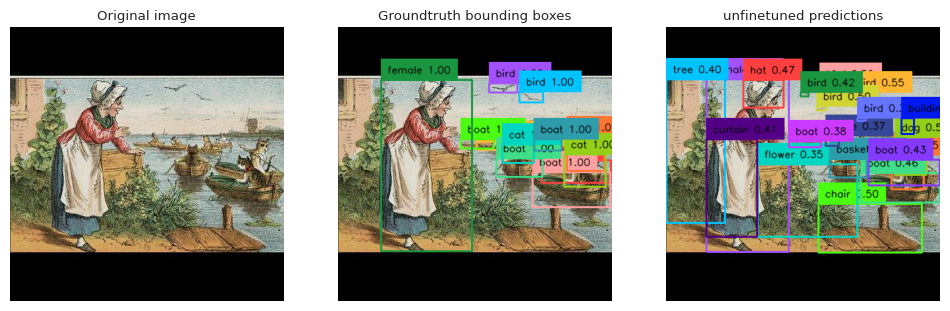

['dog', 'flower', 'window building', 'curtain']


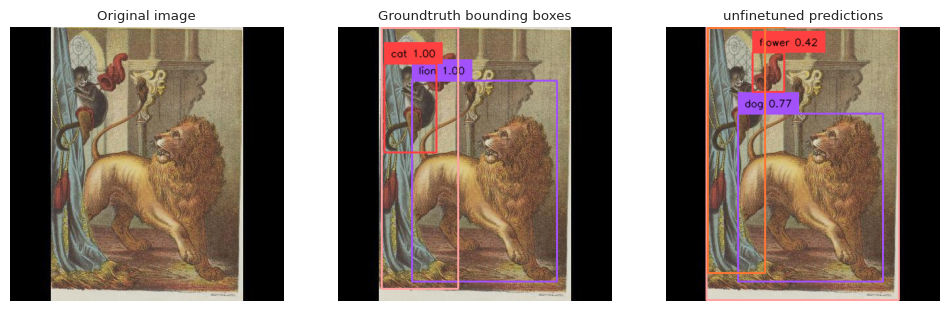

[]


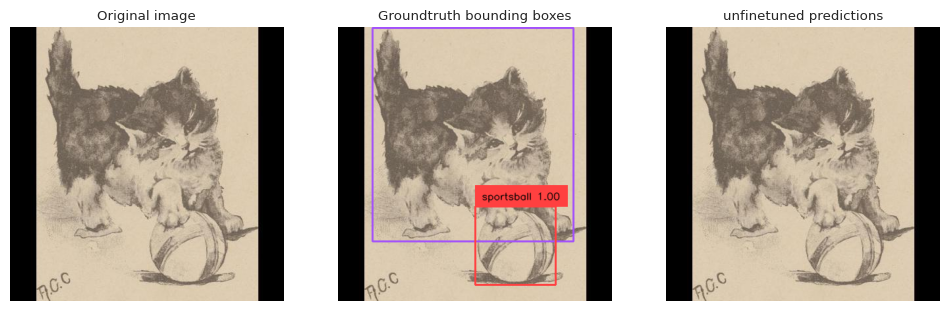

['curtain', 'dog', 'flower', 'cup', 'cup', 'window', 'cat', 'chair']


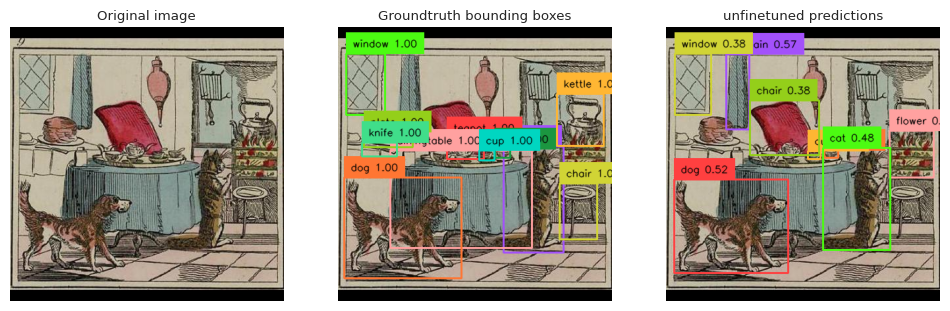

In [ ]:
for image_index in images_containing_class:
    # Get image and bbox information
    image_source, image_transformed = images[image_index]
    img_labels = labels[image_index]
    img_bboxes = bboxes[image_index]

    # set image to RGB
    image_rgb = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)

    # Get ground truth annotations
    ground_truth_image = annotate(image_source=image_source, boxes=torch.tensor(img_bboxes), logits = torch.tensor([1 for box in img_bboxes]),phrases=[classes[k] for k in img_labels])

    model.eval()
    with torch.no_grad():
        prompt = freq_classes_prompt

        # Apply model
        boxes, logits, phrases, _ = model(image_transformed.to(device), prompt)
        print(phrases)
        boxes, logits = boxes.cpu(), logits.cpu()
        predicted_image = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

    # Plot images in a (1,3) grid
    img_list = [image_rgb,ground_truth_image,predicted_image]
    sv.plot_images_grid(images=img_list,grid_size=(1,3),titles=['Original image','Groundtruth bounding boxes',f'{model_name} predictions'],size=(12,8))